# AI Kit

This jupyter notebook series constitutes a miscellaneous collection of code-snippeds for generic tasks in ML/DL-projects. The purpose is to speed up and ease model development by providing content for copying / pasting / and further customization. Each section constitutes a separat jupyter notebook.

#### A - BASICS
1. **Data Preprocessing** - Imputation, Normalization
2. **Oulier Detection** - Univariate Z-Score, Isolation Forest, Elliptic Envelope, DBSCAN
3. **Dimensionality Reduction** - PCA, tSNE

#### B - MACHINE LEARNING (SkLearn)
1. **Model Selection** - Benchmarking Algorithms with default Hyperparameters
2. **Hyperparamter Tuning** - Random Search, Learning Curves

#### C - DEEP LEARNING (Keras)
1. **Neural Nets** - Keras Sequential Model
2. **CNNs** - from Scratch, Transferlearning
3. **RNNs** - from Scratch, Transferlearning
4. **Complex Model Graphs** - Functional Keras API

## Notebook B1 - Model Selection

* [**Preprocess Data**](#pd)
* [**Classification**](#clf)
* [**Regression**](#reg)

### Preprocess Data<a name="pd"></a>

For details refer to previous notebook 1_DataPreprocessing

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

%matplotlib inline

titanic = sns.load_dataset('titanic')

# Directly remove features 'alive' and 'embark_town' which duplicate 'survived' and 'embark'
titanic = titanic.drop(columns=['embark_town', 'alive'])

# Drop feature 'deck' with too many NAs
titanic = titanic.drop(columns='deck')

# Impute age with average
titanic.loc[titanic.age.isna(), 'age'] = titanic.age.mean()

# Impute embarked with most frequent
titanic.embarked.value_counts()

# One hot encode categorical features
titanic_categorical = titanic.loc[:, (titanic.dtypes=='object') | (titanic.dtypes=='category')]
titanic = titanic.drop(columns=titanic_categorical.columns)
titanic = titanic.join(pd.get_dummies(titanic_categorical, drop_first=True))

# Convert everything to float32
titanic = titanic.astype('float32')
titanic.head()

# Lognormalize 'price'
titanic['fare'] = np.log(titanic.fare+1)

# Normalize non-categorical features
titanic.loc[:, 'pclass':'fare'] = (titanic.loc[:, 'pclass':'fare'] - titanic.loc[:, 'pclass':'fare'].mean()) /\
                                                                     titanic.loc[:, 'pclass':'fare'].std()

### Classification<a name="clf"></a>

Predict survival (yes/no) from other features.

In [12]:
import time
import warnings
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split

# Switch off future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# train_test_split() deploys shuffle=True per default
X_train, X_test, y_train, y_test = \
        train_test_split(titanic.drop('survived', axis=1), titanic.survived, test_size=0.3, random_state=42)

def assess_classifier(clf_name, clf, X_train, X_test, y_train, y_test):
    
    start_fit = time.clock()
    clf.fit(X_train, y_train)
    start_pred = time.clock()
    y_pred = clf.predict(X_test)
    finished = time.clock()
    
    miliseconds_fitting = 1000*(start_pred - start_fit)
    miliseconds_prediction = 1000*(finished - start_pred)
    clf_accuracy = accuracy_score(y_test, y_pred)
     
    return [clf_name, miliseconds_fitting, miliseconds_prediction, clf_accuracy]

clf_bench = []
for clf_name, clf in [['KNN', KNeighborsClassifier()], \
                      ['NaiveBayes', GaussianNB()], \
                      ['LogReg', LogisticRegression()], \
                      ['SvmLin', SVC(kernel='linear', random_state=42)], \
                      ['SvmPoly', SVC(kernel='poly', random_state=42)], \
                      ['SvmRBF', SVC(kernel='rbf', random_state=42)], \
                      ['DecisionTree', DecisionTreeClassifier(random_state=42)], \
                      ['RandomForest', RandomForestClassifier(random_state=42)], \
                      ['AdaBoost', AdaBoostClassifier(random_state=42)], \
                      ['GradientBoost', GradientBoostingClassifier(random_state=42)]]:
    clf_bench.append(assess_classifier(clf_name, clf, X_train, X_test, y_train, y_test))

clf_bench = pd.DataFrame(clf_bench)
clf_bench.columns = ['Classifier', 'Train_ms', 'Predict_ms', 'Accuracy']
clf_bench

,Classifier,Train_ms,Predict_ms,Accuracy
0,KNN,1.513391,3.483716,0.824627
1,NaiveBayes,1.350017,0.432137,0.809701
2,LogReg,1.754439,0.524399,0.817164
3,SvmLin,11.144754,2.008616,0.820896
4,SvmPoly,7.802167,2.111818,0.817164
5,SvmRBF,9.067215,2.196787,0.828358
6,DecisionTree,1.899214,0.376707,0.742537
7,RandomForest,14.178829,1.346006,0.779851
8,AdaBoost,48.029547,5.297596,0.817164
9,GradientBoost,59.730792,0.952889,0.828358


### Regression<a name="reg"></a>

Predict age from other features.

In [15]:
from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor

# train_test_split() deploys shuffle=True per default
X_train, X_test, y_train, y_test = \
        train_test_split(titanic.drop('age', axis=1), titanic.age, test_size=0.3, random_state=42)

def assess_regressor(reg_name, reg, X_train, X_test, y_train, y_test):
    
    start_fit = time.clock()
    reg.fit(X_train, y_train)
    start_pred = time.clock()
    y_pred = reg.predict(X_test)
    finished = time.clock()
    
    miliseconds_fitting = 1000*(start_pred - start_fit)
    miliseconds_prediction = 1000*(finished - start_pred)
    reg_rmse = sqrt(mean_squared_error(y_test, y_pred))
     
    return [reg_name, miliseconds_fitting, miliseconds_prediction, reg_rmse]

reg_bench = []
for reg_name, reg in [['KNN', KNeighborsRegressor()], \
                      ['LinReg', LinearRegression()], \
                      ['SvmLin', SVR(kernel='linear')], \
                      ['SvmPoly', SVR(kernel='poly')], \
                      ['SvmRBF', SVR(kernel='rbf')], \
                      ['DecisionTree', DecisionTreeRegressor()], \
                      ['RandomForest', RandomForestRegressor()], \
                      ['AdaBoost', AdaBoostRegressor()], \
                      ['GradientBoost', GradientBoostingRegressor()]]:
    reg_bench.append(assess_regressor(reg_name, reg, X_train, X_test, y_train, y_test))

reg_bench = pd.DataFrame(reg_bench)
reg_bench.columns = ['Regressor', 'Train_ms', 'Predict_ms', 'RMSE']
reg_bench

,Regressor,Train_ms,Predict_ms,RMSE
0,KNN,1.304433,3.221152,0.838755
1,LinReg,0.995920,0.319818,0.805855
2,SvmLin,31.227265,2.768958,0.822488
3,SvmPoly,21.852631,3.537687,0.879784
4,SvmRBF,17.758818,4.795807,0.823424
5,DecisionTree,1.820809,0.346803,0.929230
6,RandomForest,13.976071,1.199043,0.838855
7,AdaBoost,14.864413,1.350382,0.849576
8,GradientBoost,38.761397,0.907305,0.808432


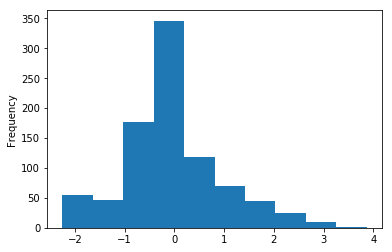

In [18]:
# Compare RMSE with normalized 'age' distri
titanic.age.plot.hist()